## Header

In [1]:
from esnb import CaseGroup2, NotebookDiagnostic, RequestedVariable
from esnb.sites.gfdl import call_dmget

mode = "prod"

# Verbosity
verbose = True

# Give your diagnostic a name and a short description
diag_name = "surface water mass transformation analysis"
diag_desc = "this is water mass transformation analysis using xwmt-new"

# Define what variables you would like to analyze. The first entry is the
# variable name and the second entry is the realm (post-processing dir).
#   (By default, monthly timeseries data will be loaded. TODO: add documentation
#    on how to select different frequencies, multiple realms to search, etc.)
variables = [
    #RequestedVariable("so", "ocean_monthly_z"),
    #RequestedVariable("thetao", "ocean_monthly_z"),
    #RequestedVariable("vmo", "ocean_monthly_z"),
    #RequestedVariable("vmo", "ocean_month_rho2"),
    #RequestedVariable("vmo", "ocean_monthly_rho2"),
    RequestedVariable("tos", "ocean_monthly"),
    RequestedVariable("sos", "ocean_monthly"),
    RequestedVariable("tauuo", "ocean_monthly"),
    RequestedVariable("tauvo", "ocean_monthly"),
    #RequestedVariable("uas", "atmos_cmip"),
    #RequestedVariable("vas", "atmos_cmip"),
    RequestedVariable("siconc", "ice"),
]

# Optional: define runtime settings or options for your diagnostic
user_options = {"N/A": ["N/A"]}

# Initialize the diagnostic with its name, description, vars, and options
diag = NotebookDiagnostic(diag_name, diag_desc, variables=variables, **user_options)

# Define the groups of experiments to analyze. Provide a single dora id for one experiment
# or a list of IDs to aggregate multiple experiments into one; e.g. historical+future runs
groups = [
    #CaseGroup2("odiv-3", date_range=("0030-01-01", "0120-12-31")),
    #CaseGroup2("odiv-519", date_range=("0200-01-01", "0250-12-31")),
    #CaseGroup2("odiv-538", date_range=("0060-01-01", "0100-12-31")),
    CaseGroup2("odiv-1", date_range=("0200-01-01", "0250-12-31")),
    CaseGroup2("odiv-3", date_range=("0060-01-01", "0100-12-31")),
]

ERROR! Session/line number was not unique in database. History logging moved to new session 674


In [2]:
diag.resolve(groups)

def diag_get():
    """
    helper function to dmget to get dsets of above vars/files
    """
    call_dmget(diag.files)
    diag.open()
diag_get()

dmget: All files are online


## Imports

In [3]:
import xwmt # This is xwmt-new
import numpy as np
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import momgrid as mg
from momgrid.geoslice import geoslice
import os as os
import cartopy.crs as ccrs
import xbudget
import xgcm
from cmip_basins.basins import generate_basin_codes
import copy
import cartopy.feature as cfeature
import cmocean
from matplotlib.lines import Line2D

os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/jpk/grid_weights" # get rid of any momgrid
variables_names = [variable.varname for variable in variables]

## Calculations

In [4]:
def realm_list():
    """
    returns dsets[i][j], s.t. i is the case experiment with all variables, and j is the realm
    """
    diag_get()
    out = []
    for g in diag.groups:
        d = g.datasets

        ds_ocean = xr.merge([
            d[v] for v in variables
            if v.varname not in ("siconc", "uas", "vas") and v in d
        ])
        
        ds_ice = xr.merge([
            d[v] for v in variables
            if v.varname == "siconc" and v in d
        ])
        
        ds_atm = xr.merge([
            d[v] for v in variables
            if v.varname in ("uas", "vas") and v in d
        ])
        
        out.append([ds_ocean, ds_ice, ds_atm])
    
    return out

def vmo_hov_lat(vmo_ds, basin_integer, lat_sel, lon_min, lon_max, resolution=.25):
    '''
    given some dataset with vmo in rho or z_l coords plots hovmoller type diagram (time, height, vmo)
    '''
    vmo_ds = ds_list[0][0]
    vmo_gs = mg.Gridset(vmo_ds)
    vmo_gs_rg = vmo_gs.regrid(resolution=resolution)
    vmo_gs_rg['vmo'] = vmo_gs_rg.vmo.where(vmo_gs_rg.vmo<1e14).load()
    if basin_integer is not None:
        basincodes = generate_basin_codes(
            vmo_gs_rg, lon="lon", lat="lat", mask="wet"
        )
        vmo_so = (
            vmo_gs_rg
            .where((basincodes == basin_integer))
            .copy(deep=True)
        )
    else: 
        vmo_so = vmo_gs_rg
    vmo_so_sel = vmo_so.sel(lon=slice(lon_min, lon_max))
    vmo_so_sel = vmo_so_sel.mean("lon")
    return vmo_so_sel

In [5]:
ds_list = realm_list()

dmget: All files are online


## plots of seasonality in Arctic

### Annual

/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:86: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:99: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:86: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:99: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping boun

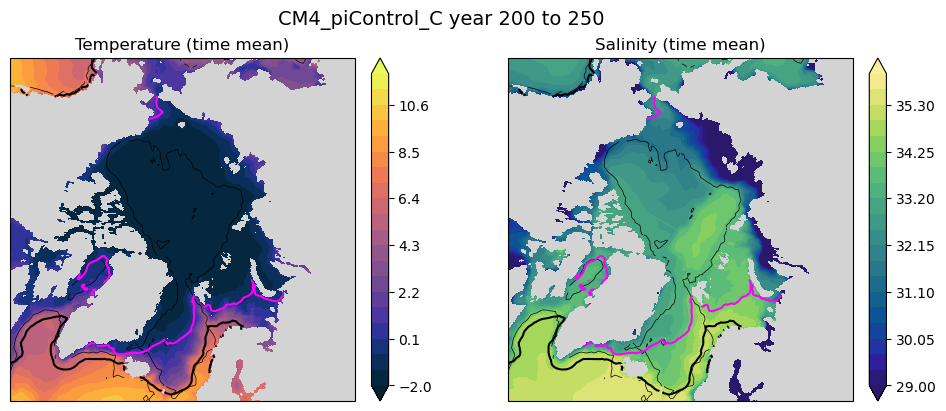

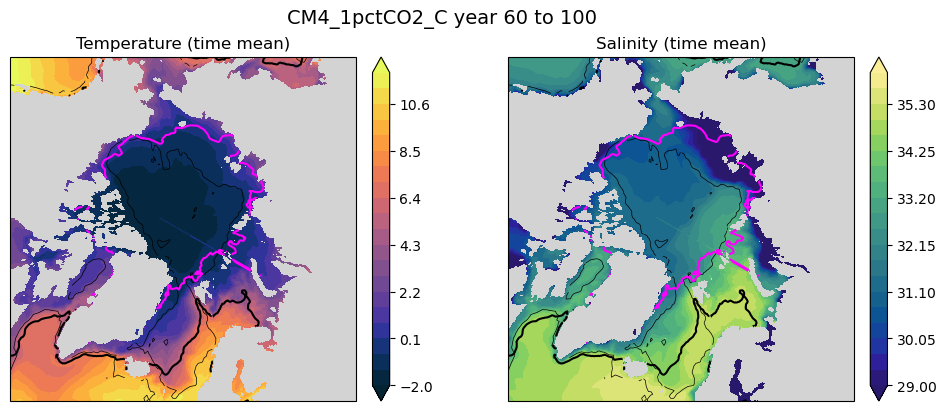

In [8]:
for idx, group_i in enumerate(groups):
    
    ds_final = []
    ocean_bool = True
    ice_bool = True
    atmos_bool = False
    
    if ocean_bool == True:
        ds = ds_list[idx][0]
        ds_gs = mg.Gridset(ds)
        deptho_1k = ds_gs.regrid(resolution=1)
        ds_gs_rg = ds_gs.regrid(resolution=0.25)
        ds_gs_rg_m = ds_gs_rg.mean("time")
        ds_final.append(ds_gs_rg_m)
        # ds ice below
    if ice_bool == True:
        ds_ice = ds_list[idx][1]
        ds_ice = ds_ice.copy(deep=True).rename({"xT": "xh", "yT": "yh"})
        ds_ice = mg.Gridset(ds_ice)
        ds_ice_rg = ds_ice.regrid(resolution=0.25)
        monthly = ds_ice_rg.groupby("time.month").mean("time")
        march = monthly.sel(month=3)
        sept = monthly.sel(month=9)
        siext_march = march.where(march["siconc"] > 0.15)
        siext_sept = sept.where(sept["siconc"] > 0.15)

        
    var_list   = (['tos', 'sos', 'tauuo', 'tauvo'])[:2]
    var_longname = (['Temperature', 'Salinity', 'u-windstress', 'v-windstress'])
    cmap_list  = ['thermal', 'haline', 'curl',  'curl']
    vmin_list  = [-2,     29,     -.1,      -.1   ]
    vmax_list  = [12,     36,     .1,       .1   ]
    min_year = ds_gs_rg.time.min().item().year
    max_year = ds_gs_rg.time.max().item().year
    
    nrows  = len(ds_final)
    ncols  = len(var_list)
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(5*ncols, 4*nrows),
        subplot_kw={'projection': ccrs.NorthPolarStereo()},
        constrained_layout=True
    )
    plt.suptitle(f"{groups[idx].name} year {min_year} to {max_year}", fontsize=14)
    axes = np.atleast_2d(axes)
    
    for i, ds in enumerate(ds_final):
        for j, var in enumerate(var_list):
            ax   = axes[i, j]
            data = ds[var]
            cmap = getattr(cmocean.cm, cmap_list[j])
            cmap.set_bad('lightgray')
            levels = np.linspace(vmin_list[j], vmax_list[j], 21)
            im = ax.contourf(
                data['lon'], data['lat'], data,
                levels=levels,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                extend='both'
            )
    
            ax.contour(
                deptho_1k.lon, deptho_1k.lat, deptho_1k.deptho,
                levels=[1000], colors='k', linewidths=0.5,
                transform=ccrs.PlateCarree()
            )
            ax.contour(
                sept.lon, sept.lat, sept.siconc,
                levels=[0.15], colors='magenta', linewidths=1.5,
                transform=ccrs.PlateCarree()
            )
            ax.contour(
                march.lon, march.lat, march.siconc,
                levels=[0.15], colors='black', linewidths=1.5,
                transform=ccrs.PlateCarree()
            )
            ax.set_facecolor('lightgray')
            ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())
            ax.set_title(f"{var_longname[j]} (time mean)")
    
            fig.colorbar(im, ax=ax, orientation='vertical',
                         fraction=0.046, pad=0.04)
    
            
    plt.savefig(f"/work5/t1a/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/windstress/arctic_{var_list}_{groups[idx].name}_{min_year}_{max_year}yr.png")

## Annual delta

/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:86: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:99: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:86: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:99: UserWarning: We

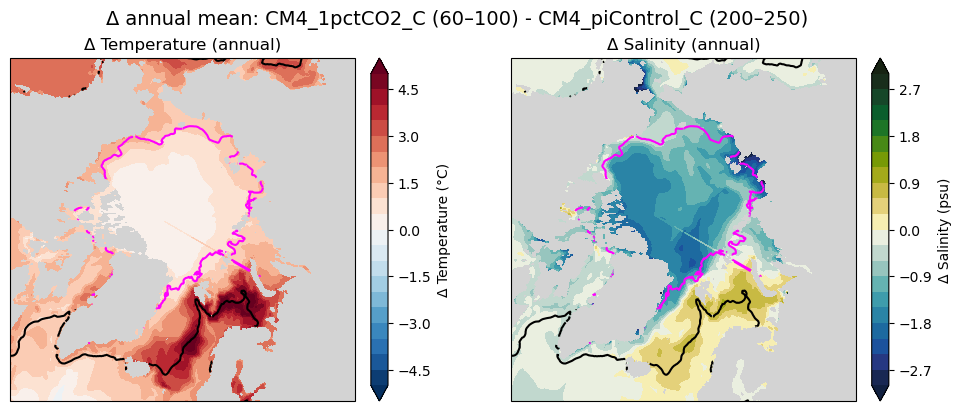

In [7]:
var_list   = ['tos','sos']
var_longname = (['Temperature', 'Salinity'])
label_list = ['Temperature (°C)','Salinity (psu)']
vmin_list = [-5, -3]
vmax_list = [5, 3]
cmap_list = ['RdBu_r', 'delta']
extent   = [-180, 180, 60, 90]

ds0_rg = mg.Gridset(ds_list[0][0]).regrid(resolution=0.25)
ds1_rg = mg.Gridset(ds_list[1][0]).regrid(resolution=0.25)
# assuming that 1pct is 2nd in list with no atmosphere vars 
ds_ice = ds_list[1][1]
ds_ice = ds_ice.copy(deep=True).rename({"xT": "xh", "yT": "yh"})
ds_ice = mg.Gridset(ds_ice)
ds_ice_rg = ds_ice.regrid(resolution=0.25)
monthly = ds_ice_rg.groupby("time.month").mean("time")
march = monthly.sel(month=3)
sept = monthly.sel(month=9)
siext_march = march.where(march["siconc"] > 0.15)
siext_sept = sept.where(sept["siconc"] > 0.15)

min0 = ds_list[0][0].time.min().dt.year.item()
max0 = ds_list[0][0].time.max().dt.year.item()
min1 = ds_list[1][0].time.min().dt.year.item()
max1 = ds_list[1][0].time.max().dt.year.item()

fig, axes = plt.subplots(
    1, 2,
    figsize=(5*2, 4*1),
    subplot_kw={'projection': ccrs.NorthPolarStereo()},
    constrained_layout=True
)

fig.suptitle(
    f"Δ annual mean: {groups[1].name} ({min1}–{max1}) - "
    f"{groups[0].name} ({min0}–{max0})",
    fontsize=14
)
axes = axes.flatten()

for ax, var, var_long, label, vmin, vmax, cmap_name in zip(axes, var_list, var_longname, label_list, vmin_list, vmax_list, cmap_list):
    ann0  = ds0_rg[var].mean('time')
    ann1  = ds1_rg[var].mean('time')
    delta = ann1 - ann0

    if hasattr(cmocean.cm, cmap_name):
        cmap = getattr(cmocean.cm, cmap_name).copy()
    else:
        cmap = plt.get_cmap(cmap_name).copy()

    levels = np.linspace(vmin, vmax, 21)

    pcm = ax.contourf(
        delta.lon, delta.lat, delta,
        levels=levels,
        cmap=cmap, extend='both',
        transform=ccrs.PlateCarree()
    )
    
    ax.contour(
        sept.lon, sept.lat, sept.siconc,
        levels=[0.15], colors='magenta', linewidths=1.5,
        transform=ccrs.PlateCarree()
    )
    ax.contour(
        march.lon, march.lat, march.siconc,
        levels=[0.15], colors='black', linewidths=1.5,
        transform=ccrs.PlateCarree()
    )

    ax.set_facecolor('lightgray')
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_title(f"Δ {var_long} (annual)")

    fig.colorbar(
        pcm, ax=ax, orientation='vertical',
        fraction=0.046, pad=0.04,
        label=f"Δ {label}"
    )

plt.savefig(f"/work5/t1a/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/presentation/"
                f"delta_arctic_{var_list}_{groups[1].name}{min1}_{max1}yr_{groups[0].name}_{min0}_{max0}yr.png")

### Monthly

/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:86: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:99: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgr

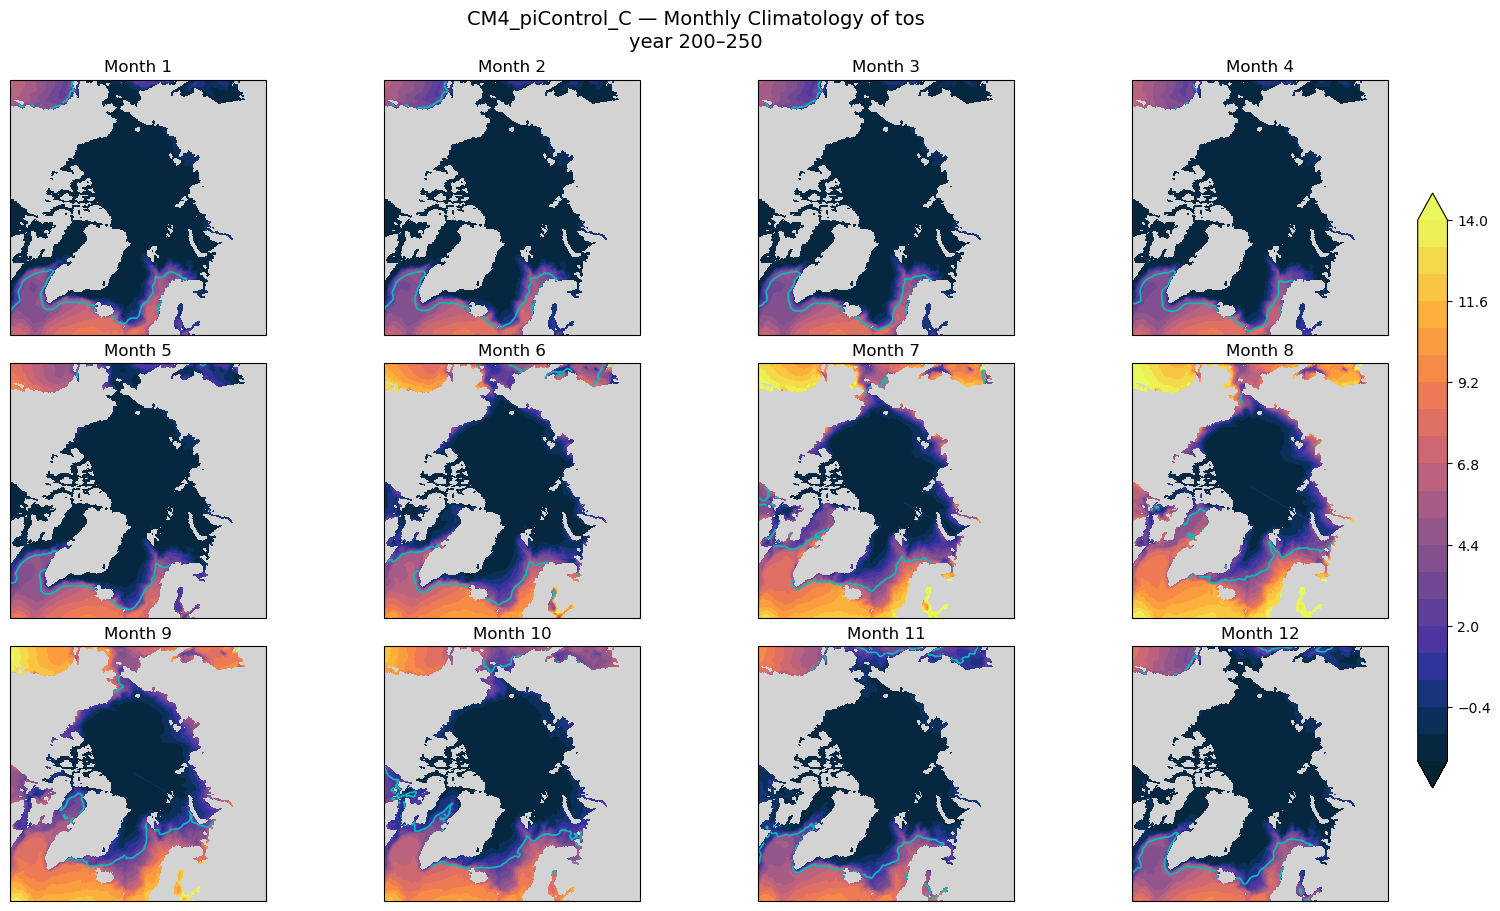

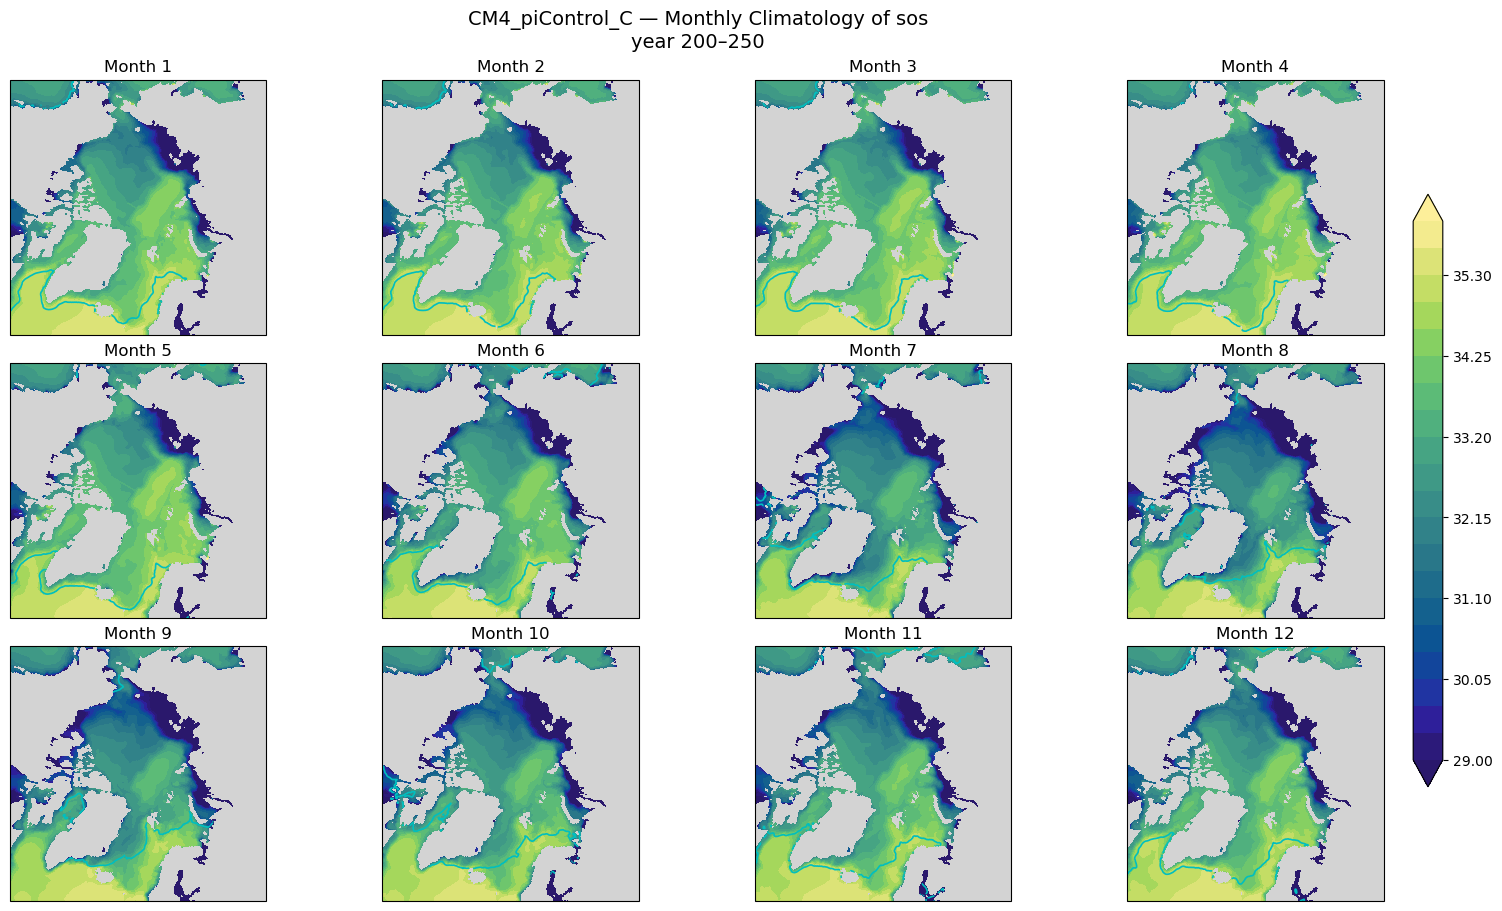

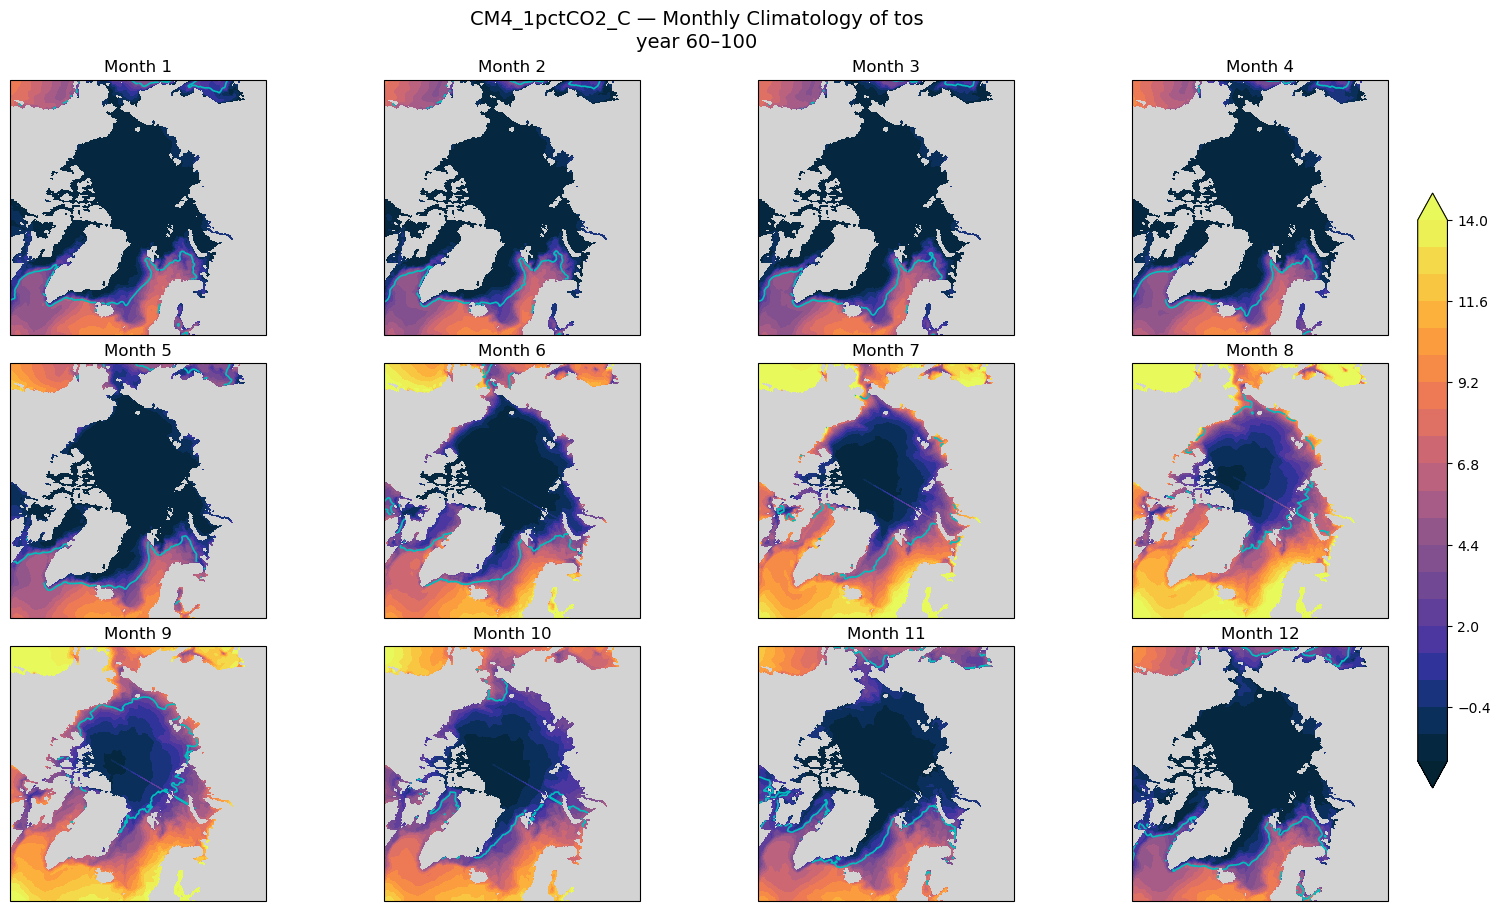

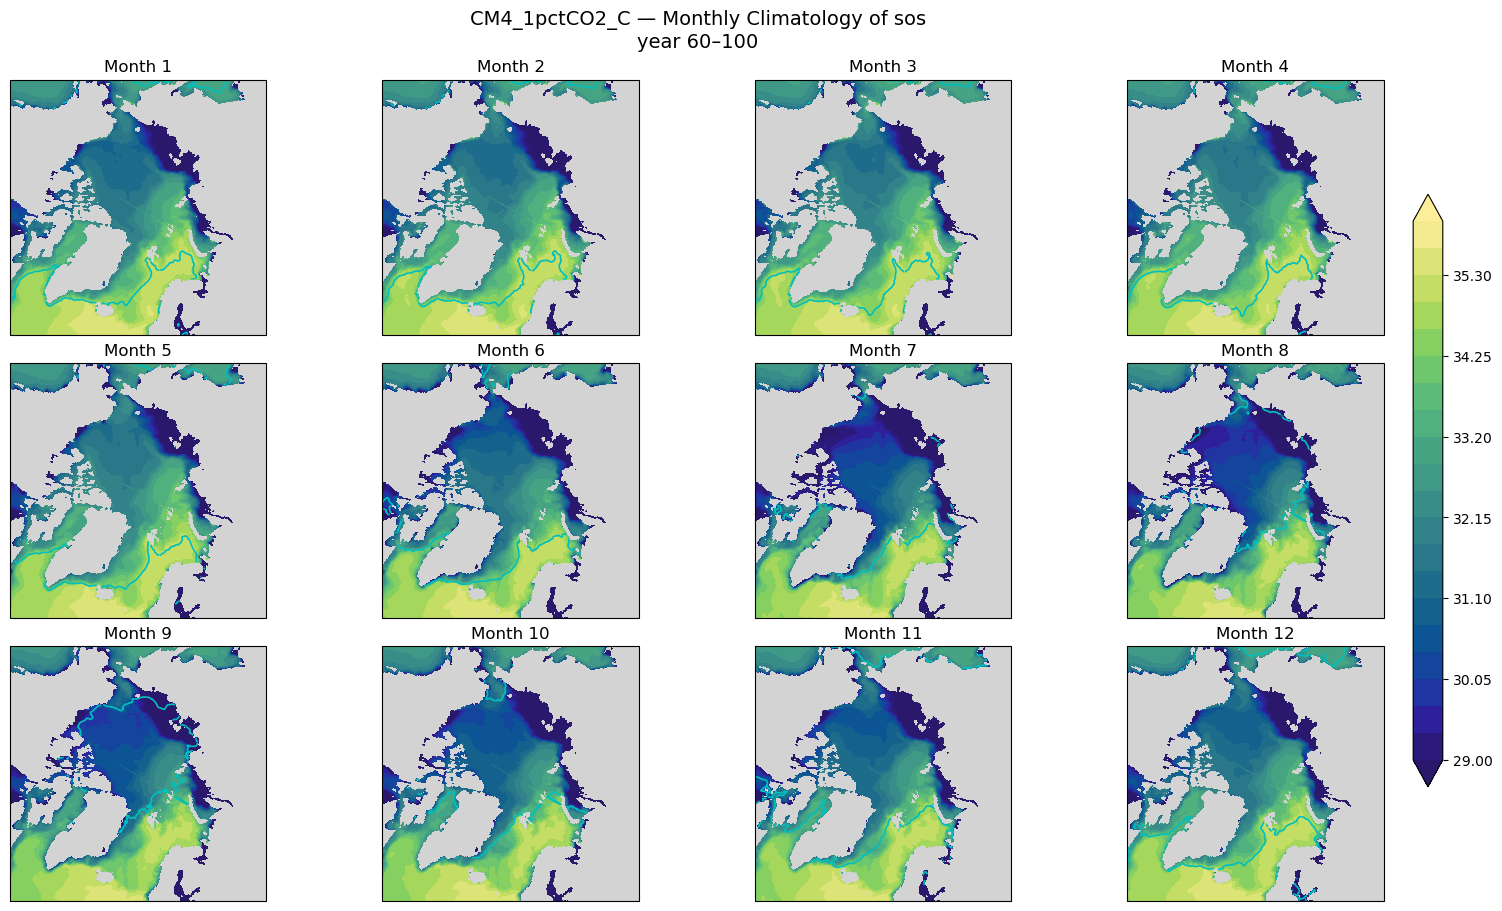

In [14]:
months   = np.arange(1,13)
extent   = [-180, 180, 60, 90]   # adjust as you like

# plotting parameters per variable
var_list  = ['tos',   'sos',   'tauuo',   'tauvo']
cmap_dict = {
    'tos':   'thermal',
    'sos':   'haline',
    'tauuo': 'curl',
    'tauvo': 'curl',
}
vmin_dict = {
    'tos':   -2, 
    'sos':    29,
    'tauuo': -0.1,
    'tauvo': -0.1,
}
vmax_dict = {
    'tos':    14,
    'sos':    36,
    'tauuo':   0.1,
    'tauvo':   0.1,
}


for idx, grp in enumerate(groups):
    ds_ocean  = ds_list[idx][0]
    ds_ice    = ds_list[idx][1].copy().rename({'xT':'xh','yT':'yh'})

    ds_ocean_rg = mg.Gridset(ds_ocean).regrid(resolution=0.25)
    ds_ice_rg   = mg.Gridset(ds_ice).regrid(resolution=0.25)

    ice_clim = ds_ice_rg['siconc'].groupby('time.month').mean('time')
    min_year = ds_ice_rg.time.min().item().year
    max_year = ds_ice_rg.time.max().item().year

    for var in var_list[:2]:
        clim = ds_ocean_rg[var].groupby('time.month').mean('time')

        fig, axes = plt.subplots(
            3, 4,
            figsize=(4*4, 3*3),
            subplot_kw={'projection': ccrs.NorthPolarStereo()},
            constrained_layout=True
        )
        axes = axes.flatten()

        plt.suptitle(
            f"{grp.name} — Monthly Climatology of {var}\n"
            f"year {min_year}–{max_year}",
            fontsize=14
        )

        cmap = getattr(cmocean.cm, cmap_dict[var])
        cmap.set_bad("black")
        vmin, vmax = vmin_dict[var], vmax_dict[var]
        levels = np.linspace(vmin, vmax, 21)

        for i, month in enumerate(months):
            ax = axes[i]
            da = clim.sel(month=month)

            mesh = ax.contourf(
                da.lon, da.lat, da,
                levels=levels,
                transform=ccrs.PlateCarree(),
                cmap=cmap,
                extend='both'
            )
            ax.set_facecolor('lightgray')
            ice = ice_clim.sel(month=month)
            ax.contour(
                ice.lon, ice.lat, ice,
                levels=[0.15],
                colors='c', linewidths=1.2,
                transform=ccrs.PlateCarree()
            )

            ax.set_extent(extent, crs=ccrs.PlateCarree())
            ax.set_title(f"Month {month}")

        fig.colorbar(
            mesh, ax=axes.tolist(),
            orientation='vertical',
            fraction=0.02, pad=0.02
        )
        plt.savefig(f"/work5/t1a/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/windstress/arctic_monthly_{var}_{groups[idx].name}_{min_year}_{max_year}yr.png")

### delta monthly mag ws 

/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:86: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:99: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:86: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:99: UserWarning: We

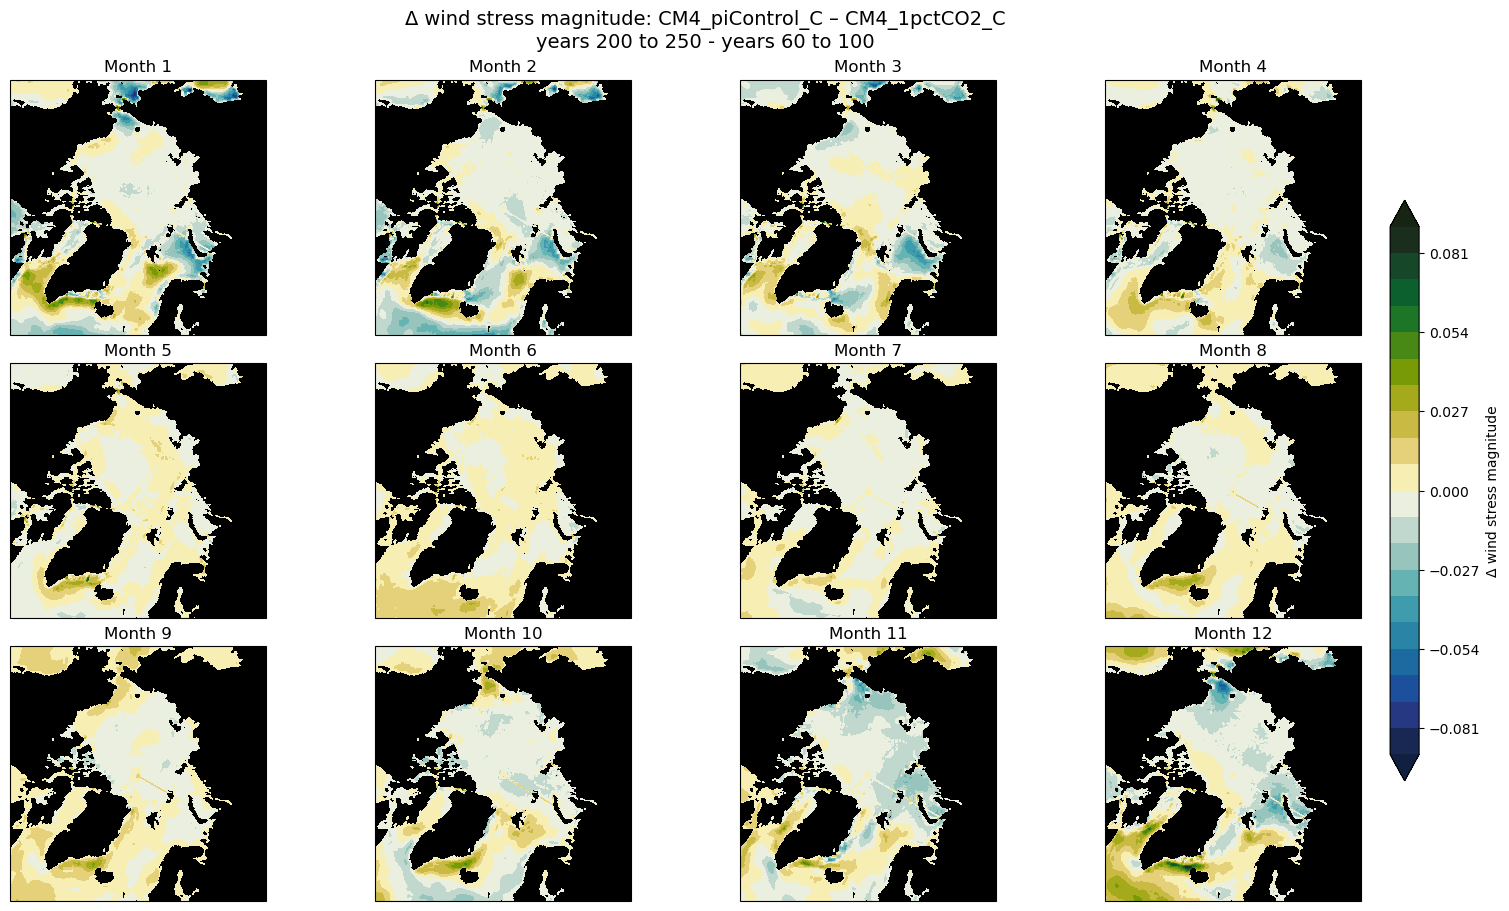

In [54]:
months = np.arange(1,13)
extent = [-180, 180, 60, 90]
var = 'wind stress magnitude'                  

ds0_rg = mg.Gridset(ds_list[0][0]).regrid(resolution=0.25)
ds1_rg = mg.Gridset(ds_list[1][0]).regrid(resolution=0.25)

mag0 = (
    ((ds0_rg['tauuo']**2 + ds0_rg['tauvo']**2)**0.5)
    .groupby('time.month')
    .mean('time')
)
mag1 = (
    ((ds1_rg['tauuo']**2 + ds1_rg['tauvo']**2)**0.5)
    .groupby('time.month')
    .mean('time')
)

delta = mag0 - mag1

fig, axes = plt.subplots(
    3, 4,
    figsize=(4*4, 3*3),
    subplot_kw={'projection': ccrs.NorthPolarStereo()},
    constrained_layout=True
)
axes = axes.flatten()
plt.suptitle(
    f"Δ {var}: {groups[0].name} – {groups[1].name}\n"
    f"years {ds_list[0][0].time.min().dt.year.item()} to {ds_list[0][0].time.max().dt.year.item()} - years {ds_list[1][0].time.min().dt.year.item()} to {ds_list[1][0].time.max().dt.year.item()}",
    fontsize=14
)

#dmax = np.nanmax(np.abs(delta))
levels = np.linspace(-.09, .09, 21)
cmap   = cmocean.cm.delta.copy()
cmap.set_bad('black')

for i, month in enumerate(months):
    ax = axes[i]
    da = delta.sel(month=month)

    mesh = ax.contourf(
        da.lon, da.lat, da,
        levels=levels,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        extend='both'
    )
    ax.set_facecolor('black')
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.set_title(f"Month {month}")

fig.colorbar(
    mesh, ax=axes.tolist(),
    orientation='vertical',
    fraction=0.02, pad=0.02,
    label=f"Δ {var}"
)
plt.savefig(f"/work5/t1a/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/windstress/arctic_monthly_delta_tau_mag_{groups[0].name}_minus_{groups[1].name}_{min_year}_{max_year}yr.png")

### monthly tos sos

/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:86: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:99: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:86: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:99: UserWarning: We

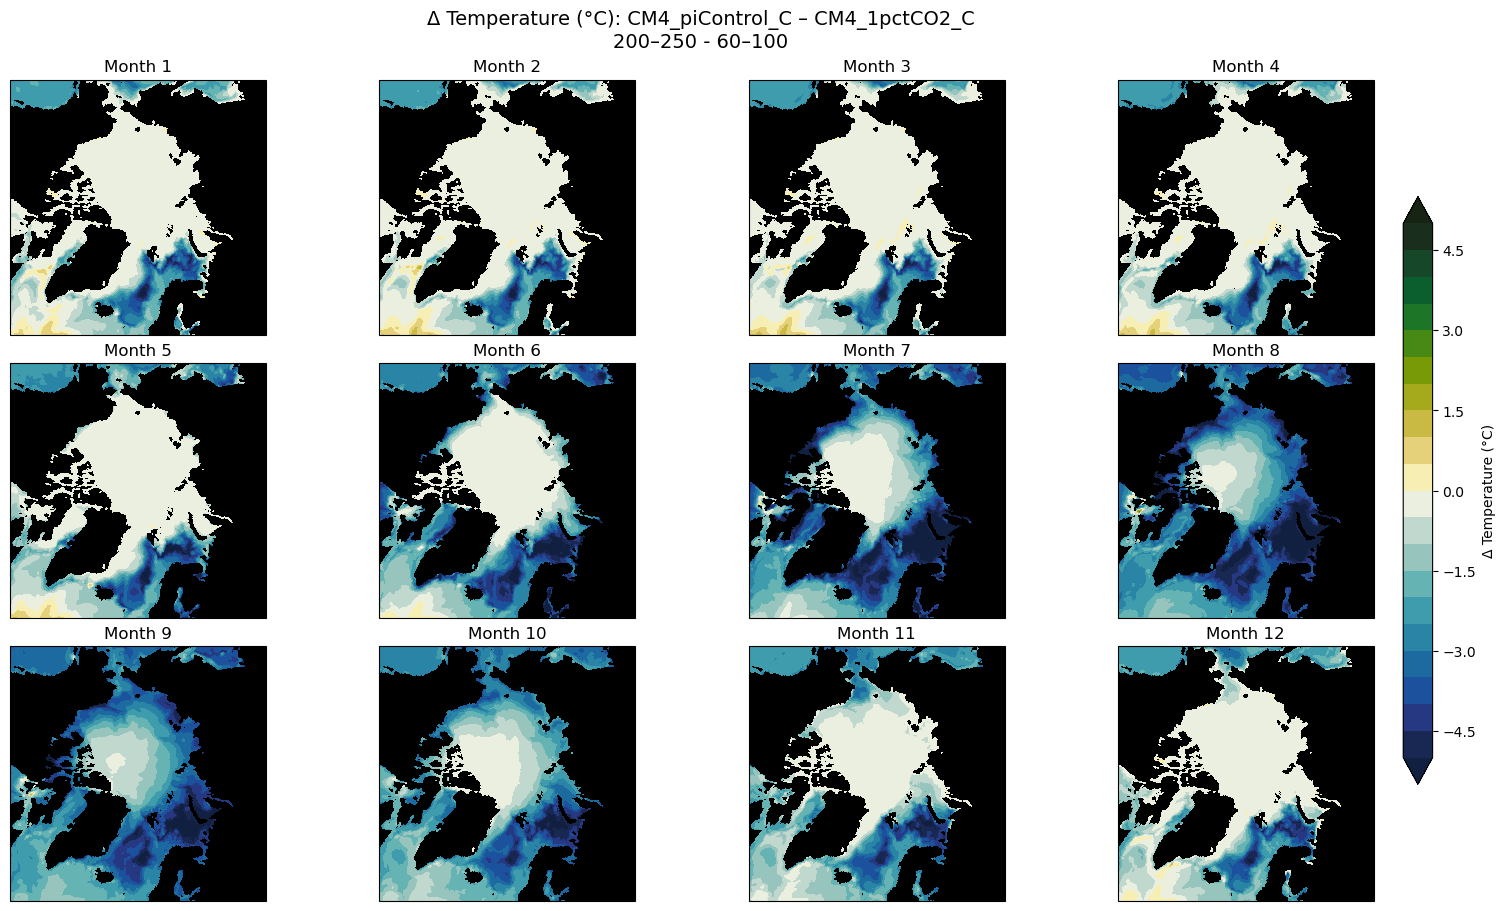

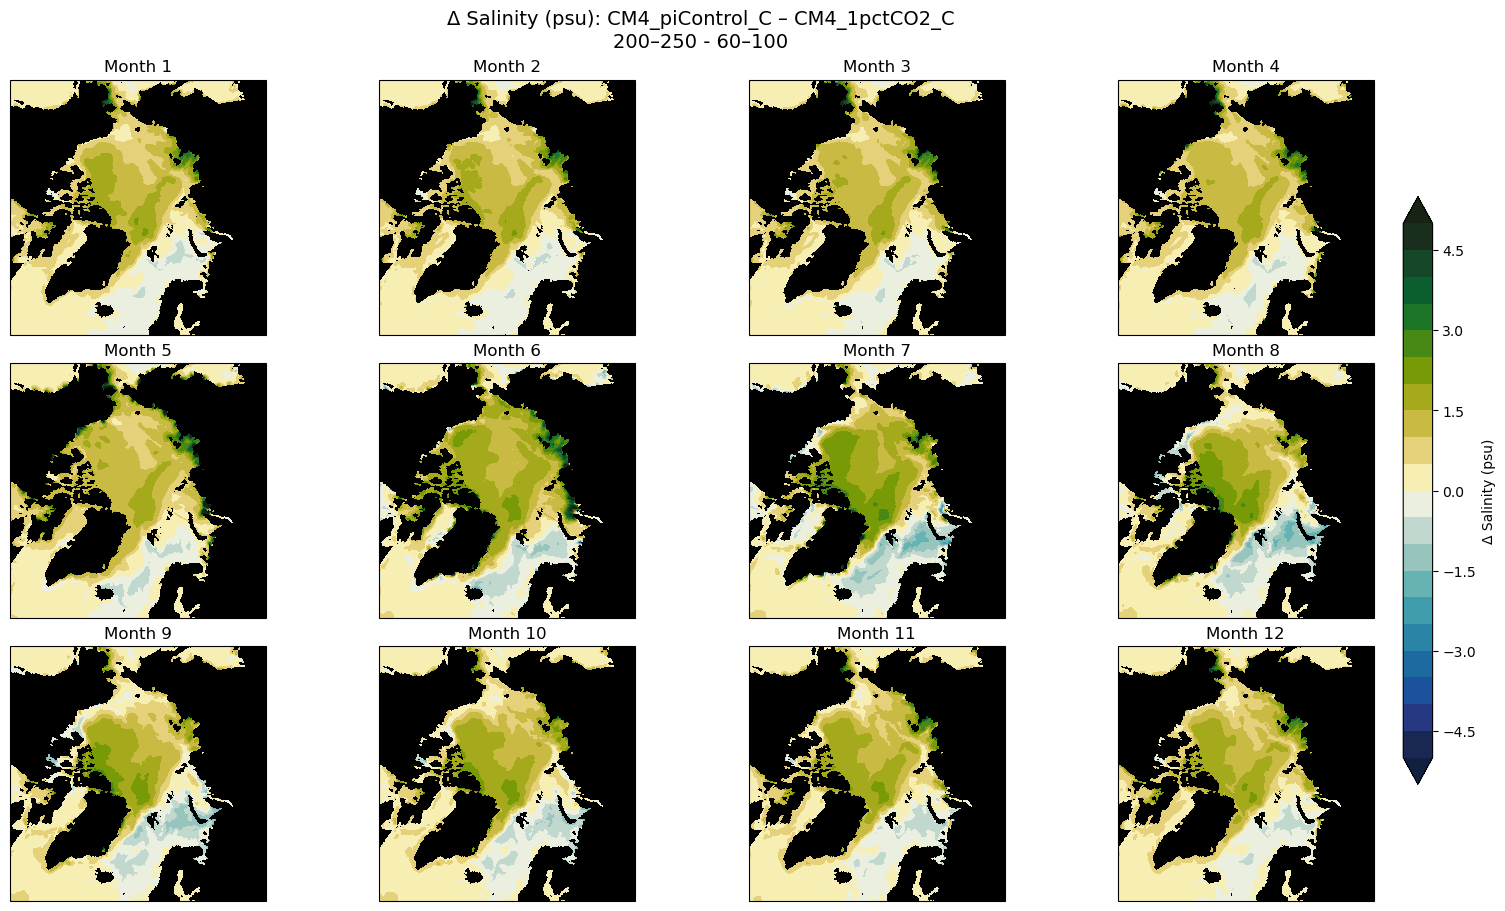

In [55]:
extent = [-180, 180, 60, 90]

for var,label in [('tos','Temperature (°C)'), ('sos','Salinity (psu)')]:
    ds0_rg = mg.Gridset(ds_list[0][0]).regrid(resolution=0.25)
    ds1_rg = mg.Gridset(ds_list[1][0]).regrid(resolution=0.25)

    clim0 = ds0_rg[var].groupby('time.month').mean('time')
    clim1 = ds1_rg[var].groupby('time.month').mean('time')

    delta = clim0 - clim1

    dmax = float(np.nanmax(np.abs(delta)))
    levels = np.linspace(-5, 5, 21)
    cmap   = cmocean.cm.delta.copy()
    cmap.set_bad('black')

    fig, axes = plt.subplots(
        3, 4,
        figsize=(4*4, 3*3),
        subplot_kw={'projection': ccrs.NorthPolarStereo()},
        constrained_layout=True
    )
    axes = axes.flatten()
    fig.suptitle(
        f"Δ {label}: {groups[0].name} – {groups[1].name}\n"
        f"{ds_list[0][0].time.min().dt.year.item()}–{ds_list[0][0].time.max().dt.year.item()} - "
        f"{ds_list[1][0].time.min().dt.year.item()}–{ds_list[1][0].time.max().dt.year.item()}",
        fontsize=14
    )

    for ax, month in zip(axes, months):
        da = delta.sel(month=month)
        pcm = ax.contourf(
            da.lon, da.lat, da,
            levels=levels, cmap=cmap, extend='both',
            transform=ccrs.PlateCarree()
        )
        ax.set_facecolor('black')
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.set_title(f"Month {month}")

    cbar = fig.colorbar(
        pcm, ax=axes.tolist(), orientation='vertical',
        fraction=0.02, pad=0.02, label=f"Δ {label}"
    )

    plt.savefig(f"/work5/t1a/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/windstress/arctic_monthly_delta_{var}_{groups[0].name}_minus_{groups[1].name}_{min_year}_{max_year}yr.png")

#### Percent Diff

In [ ]:
months = np.arange(1,13)
extent = [-180, 180, 60, 90]

for var,label in [('tos','Temperature (°C)'), ('sos','Salinity (psu)')]:
    ds0_rg = mg.Gridset(ds_list[0][0]).regrid(resolution=0.25)
    ds1_rg = mg.Gridset(ds_list[1][0]).regrid(resolution=0.25)

    clim0 = ds0_rg[var].groupby('time.month').mean('time')
    clim1 = ds1_rg[var].groupby('time.month').mean('time')

    pct = (clim0 - clim1) / clim1 * 100

    lev = np.linspace(-100, 100, 101)
    cmap = cmocean.cm.balance.copy()  
    cmap.set_bad('black')

    fig, axes = plt.subplots(
        3, 4,
        figsize=(16, 12),
        subplot_kw={'projection': ccrs.NorthPolarStereo()},
        constrained_layout=True
    )
    axes = axes.flatten()
    fig.suptitle(
        f"%Δ {label}: {groups[0].name} vs {groups[1].name}",
        fontsize=14
    )

    for ax, month in zip(axes, months):
        da = pct.sel(month=month)
        pcm = ax.contourf(
            da.lon, da.lat, da,
            levels=lev, cmap=cmap, extend='both',
            transform=ccrs.PlateCarree()
        )
        ax.set_facecolor('black')
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        ax.set_title(f"Month {month}")

    cbar = fig.colorbar(
        pcm, ax=axes.tolist(),
        orientation='vertical', fraction=0.02, pad=0.02,
        label=f"%Δ {label}"
    )
    plt.savefig(f"/work5/t1a/wmt_summer25/xwmt_cm5_diagnostics/notebooks/diag_plots/windstress/prct_arctic_monthly_delta_{var}_{groups[0].name}_minus_{groups[1].name}_{ds1_rg.time.min().item().year}_{ds1_rg.time.max().item().year}yr.png")

/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:86: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:99: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:73: UserWarning: Grid is not symmetric, skipping bounds
  warnings.warn("Grid is not symmetric, skipping bounds")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:86: UserWarning: Wet mask not present.
  warnings.warn("Wet mask not present.")
/nbhome/ogrp/python/pkgs/momgrid/src/momgrid/external.py:99: UserWarning: We